# Machine Translation Competition

**Contributor: Md Shahidur Rahaman**

*This work is inspired from the google research code: This study uses Effective Approaches to Attention-based Neural Machine Translation to train a sequence to sequence (seq2seq) model for Spanish to English translation.*

link : *https://www.tensorflow.org/text/tutorials/nmt_with_attention?fbclid=IwAR3Aq7a8iyip3Fx-OlUDAtp81UGIhm-bGX4dhVS-QdpdbIbq6S0a-ipbUEU*

In [395]:
#TF.Text is a TensorFlow library of text related operation, modules, and subgraphs.
!pip install "tensorflow-text==2.8.*"

In [396]:
#Importing package Libraries
import numpy as np
import typing
from typing import Any, Tuple
import tensorflow as tf
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [397]:
#Switching between custom to Builtin Implementation
use_builtins = True

In [398]:
#Checking the Shape for the model
class ShapeChecker():
  def __init__(self):
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')
    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue
      if old_dim is None:
        self.shapes[name] = new_dim
        continue
      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [399]:
#Data Load from the Source and Tokens
def load_data_old(path):
  source_file = "sentencesTrain.txt"
  target_file = "tokensTrain.txt"
  text_pairs_source = []
  text_pairs_target = []
  with open(source_file,encoding="unicode_escape") as file1, open(target_file,encoding="unicode_escape") as file2:
      for line1, line2 in zip(file1, file2):
          line1 = line1.replace("\n", " ")
          line1 = line1.strip()
          
          line2 = line2.replace(",", " ")
          line2 = line2.replace("\n", " ")
          line2 = line2.strip()
          text_pairs_source.append(line1)
          text_pairs_target.append(line2)
          print(line2)
  return text_pairs_target,text_pairs_source

In [400]:
#Data Load from the Source and Tokens
def load_data(path):
  source_file = "sentencesTrain.txt"
  target_file = "tokensTrain.txt"
  text_pairs_source = []
  text_pairs_target = []
  with open(source_file,encoding="unicode_escape") as file1, open(target_file,encoding="unicode_escape") as file2:
      for line1, line2 in zip(file1, file2):
          line1 = line1.replace("\n", " ")
          line1 = line1.strip()
          
          line2 = line2.replace(",", " ").replace("\n", " ").strip()
          # line2 = line2.replace("\n", " ")
          # line2 = line2.strip()
          text_pairs_source.append(line1)
          text_pairs_target.append(line2)
          print(line2)
  return text_pairs_target,text_pairs_source

In [401]:
#Checking Data
targ, inp = load_data("")
print(inp[-1])

(P)PARTY START WHICH TIME EIGHT TIME NINE (P)PARTY START WHICH TIME
(G/Q)POSS-1p SISTER (2h)IX-3p:i tube skipping on water IX-1p GO-BY-BOAT IX-1p LOOK MAKE REALLY person flips off IX-1p STOP SISTER (2h)IX-3p:i tube skipping on water GO-BY-BOAT MAKE STOP
MOTHER IX-loc:i #IF+ (1h)HAVE TIME+ IX-3p:i FUTURE BRING COOKIE TIME+ BRING COOKIE
#NO+ IX-1p NOT OLD ENOUGH TO/UNTIL VOTE THAT TIME part:indef ENOUGH TO/UNTIL VOTE TIME part:indef
FRIEND WANT_2 BUY PLAID (2h)SHIRT FRIEND WANT_2 BUY (2h)SHIRT
#IF TOMORROW SNOW GUARANTEE SCHOOL FUTURE CLOSE-DOOR SNOW GUARANTEE SCHOOL CLOSE-DOOR
IX-1p RECENT-PAST DRINK TASTE FINE++ (1h)part:indef
#IF MOTHERwg IX-3p:i NOT person walking SELL IX-1p-pl-arc REFUSE (1h)HAVE MILK part:indef SELL (1h)part:indef part:indef
FINEwg MOTHERwg FUTURE GIVE-1p TWENTY DOLLAR #IF IX-1p NICE/CLEAN (K)KITCHEN DOLLAR NICE/CLEAN (K)KITCHEN
TEACH+AGENT IX-loc:i IX-3p-pl-arc HEAR/LISTEN IX-3p:i WHO TEACH AGENT BUOY IX-3p:j
IX-1p RECENT-PAST READ+ BOOK IX-1p READ+ BOOK
EXPRESS T

In [402]:
print(targ[0:2])
print(inp[0:2])

['(P)PARTY START WHICH TIME EIGHT TIME NINE (P)PARTY START WHICH TIME', '(G/Q)POSS-1p SISTER (2h)IX-3p:i tube skipping on water IX-1p GO-BY-BOAT IX-1p LOOK MAKE REALLY person flips off IX-1p STOP SISTER (2h)IX-3p:i tube skipping on water GO-BY-BOAT MAKE STOP']
['When does the party start, at 8 or 9?', 'When my sister goes water tubing, I will have to watch her and make sure to stop the boat when she falls off.']


In [403]:
#Shuffling and batching from the arrays of string to tf.data.Dataset strings
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [404]:
#Data Checking
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b"Bob hasn't gone to the post office."
 b'My friend loves the Internet because there are many different websites.'
 b"The set up of the two categories was based on Edward Hall's analysis from the idea he presented years ago."
 b'Where are the clothes that are on sale?'
 b'If the students listen to their teacher, they will learn something.'], shape=(5,), dtype=string)

tf.Tensor(
[b'fs-BOB IX-loc:i NOT-YET GO #PO IX-3p:i GO'
 b'POSS-1p FRIEND KISS-FIST SURF-INTERNET INTERNET (25)WHY CLICK FINEwg FLOW DIFFERENT+ fs-SITES FLOW++ FRIEND INTERNET FLOW DIFFERENT+ FLOW++'
 b'BELOW_2 ON THAT ANALYZE_3 FROM (1)GENERATIONS-AGO+ IDEA SUGGEST fs-EDWARD fs-HALL BELOW_2 ON ANALYZE_3 FROM (1)GENERATIONS-AGO+ SUGGEST'
 b'DRESS/CLOTHES IX-3p:i #SALE WHERE DRESS/CLOTHES'
 b'#IF hesitation IX-3p:i STUDENT PROCEED HEAR/LISTEN TEACH+AGENT LOOK-UP FUTURE LEARN SOMETHING/ONE STUDENT PROCEED TEACH AGENT LEARN'], shape=(5,), dtype=string)


In [405]:
#Standardization for the Unicode using  text standardization function
def tf_lower_v3(text):
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [406]:
#Converting input sequence to sequence of token
max_vocab_size = 4000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_v3,
    max_tokens=max_vocab_size)

In [407]:
input_text_processor.adapt(inp)
input_text_processor.get_vocabulary()[:10] # Checking the first 10 vocab

['', '[UNK]', '[START]', '[END]', 'the', 'I', 'to', 'If', 'a', 'is']

In [408]:
#Adapting the Sequence
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_v3,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'IX-1p',
 'FRIEND',
 'IX-3p:i',
 'part:indef',
 'IX-loc:i',
 '(1h)part:indef']

In [409]:
#Converting a batch of strings into a batch of token IDs
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   39,  154,  156,    6,    4,  133, 1100,    3,    0],
       [   2,   21,   15,   62,    4,  307,   18,  130,   37,  153],
       [   2,   24,  263,  146,   19,    4,  256, 1375,   29,  300]])>

In [410]:
#Converting the ID-Tokens to Text
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

"[START] Bob hasn't gone to the post office. [END]                     "

In [411]:
#Defining the Constant
embedding_dim = 256
units = 1024

In [412]:
#Encoder takes a list of token IDs and teturns the processed sequence with internal state which will be used to initialize the decoder
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [413]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 30)
Encoder output, shape (batch, s, units): (64, 30, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [414]:
#This tutorial uses Bahdanau's additive attention. TensorFlow includes implementations of both as layers.Attention and layers.AdditiveAttention. 
#The class below handles the weight matrices in a pair of layers.Dense layers, and calls the builtin implementation.

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [415]:
#Creating a BahdanauAttention layer:
attention_layer = BahdanauAttention(units)

In [416]:
(example_tokens != 0).shape

TensorShape([64, 30])

In [417]:
#vectorized implementation of the attention layer lets you pass a batch 
#of sequences of query vectors and a batch of sequence of value vectors. 
#This will return a batch of sequences of result vectors the size of the queries.
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 30)


Text(0.5, 1.0, 'Mask')

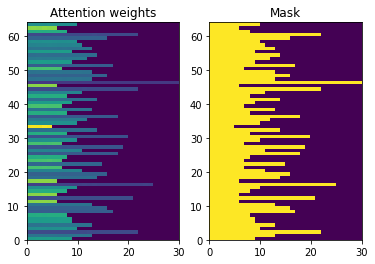

In [418]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


In [419]:
attention_weights.shape

TensorShape([64, 2, 30])

In [420]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

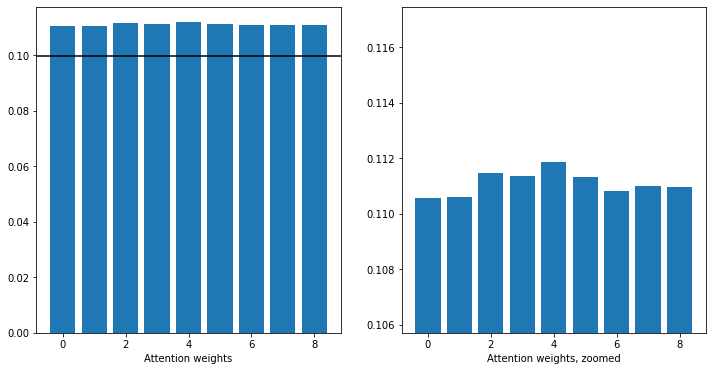

In [421]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [422]:
#The decoder will predict the next output token.

class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [423]:
#This layer's call function accepts and returns several tensors. Sort them into basic container classes.
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [424]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [425]:
Decoder.call = call

In [426]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [427]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [428]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 1294)
state shape: (batch_size, dec_units) (64, 1024)


In [429]:
#Sample a token according to the logits:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [430]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['long'],
       ['(1h)VOMIT/HATE'],
       ['FAST_3'],
       ['HAMBURGER'],
       ['(2h)alt.TEASE']], dtype='<U33')

In [431]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [432]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['TIE_2+FISHING'],
       ['GLASSES_2'],
       ['pay'],
       ['GRADUATE'],
       ['DINNER+']], dtype='<U33')

In [433]:
#Defining the loss function
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [434]:
#The training process will be implemented as the train_step method on this model
#The train step function acts as a wrapper for the _train step implementation, which will be provided later. 
#To facilitate debugging, this wrapper offers a switch for turning on and off tf.function compilation.
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [435]:
#Preprocessing
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [436]:
TrainTranslator._preprocess = _preprocess

In [437]:
#Except for actually executing the decoder, the '_train step' function added below handles the other steps:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))
  return {'batch_loss': average_loss}

In [438]:
TrainTranslator._train_step = _train_step

In [439]:
#The _loop step method runs the decoder and calculates the incremental loss and new decoder state (dec state).
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [440]:
TrainTranslator._loop_step = _loop_step

In [441]:
#Creating a TrainTranslator and configure it for Model-based training. technique of compilation:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [442]:
np.log(output_text_processor.vocabulary_size())

7.165493475060845

In [443]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.666546>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.638779>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.5918975>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.466107>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.963992>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.171035>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.4049816>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.5426936>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.5852084>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.4214463>}

CPU times: user 20.9 s, sys: 201 ms, total: 21.1 s
Wall time: 28.5 s


In [444]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [445]:
TrainTranslator._tf_train_step = _tf_train_step

In [446]:
translator.use_tf_function = True

In [447]:
#Functional Tracing
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.155012>}

In [448]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.2503495>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.0181503>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.993133>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.966715>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9424453>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.916118>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.882797>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8399377>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7872624>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.726808>}

CPU times: user 7.93 s, sys: 813 ms, total: 8.74 s
Wall time: 5.19 s


....................................................................................................


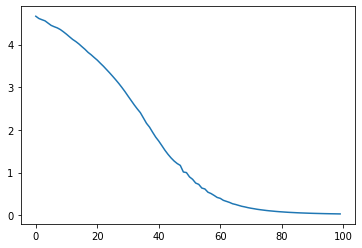

In [449]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [450]:
#Build a fresh copy of the Model
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [451]:
#Model Training
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [452]:
#Running with 50 epochs
train_translator.fit(dataset, epochs=50,
                     callbacks=[batch_loss])

Epoch 1/50
11/11 [==============================] - 12s 519ms/step - batch_loss: 6.4550
Epoch 2/50
11/11 [==============================] - 6s 506ms/step - batch_loss: 5.7013
Epoch 3/50
11/11 [==============================] - 6s 503ms/step - batch_loss: 5.4745
Epoch 4/50
11/11 [==============================] - 6s 521ms/step - batch_loss: 5.2927
Epoch 5/50
11/11 [==============================] - 6s 515ms/step - batch_loss: 5.1462
Epoch 6/50
11/11 [==============================] - 6s 519ms/step - batch_loss: 4.9748
Epoch 7/50
11/11 [==============================] - 6s 524ms/step - batch_loss: 4.8217
Epoch 8/50
11/11 [==============================] - 5s 495ms/step - batch_loss: 4.5490
Epoch 9/50
11/11 [==============================] - 5s 497ms/step - batch_loss: 4.2585
Epoch 10/50
11/11 [==============================] - 5s 443ms/step - batch_loss: 3.9761
Epoch 11/50
11/11 [==============================] - 5s 426ms/step - batch_loss: 3.6327
Epoch 12/50
11/11 [=====================

Text(0, 0.5, 'CE/token')

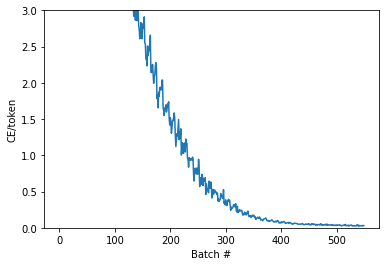

In [453]:
#Generating Loss Graphics
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [454]:
#Text to Text Translation
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [455]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [456]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [457]:
Translator.tokens_to_text = tokens_to_text

In [458]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'fs-LATE EYES', b'#BQQ STORY', b'SHORTS BAKE/OVEN', b'LOOK USE+',
       b'group SUPPORT+'], dtype=object)

In [459]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [460]:
Translator.sample = sample

In [461]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[607],
       [879],
       [ 75],
       [ 65],
       [331]])>

In [462]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    done = done | (new_tokens == self.end_token)
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [463]:
Translator.translate = translate_unrolled

In [464]:
%%time
input_text = tf.constant([
    'I just drank it and it tastes fine.',
    'I just read a book.',
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

IX-1p RECENT-PAST DRINK TASTE FINE++ (1h)part:indef
IX-1p RECENT-PAST READ+ BOOK IX-1p READ+ BOOK

CPU times: user 287 ms, sys: 6.56 ms, total: 293 ms
Wall time: 300 ms


In [465]:
#Generating Output text
test_file = "sentencesTest.txt"

outputfile = "sign_rahaman_nmt_v16.txt"
out = open(outputfile, "w")

with open(test_file, encoding="unicode_escape" ) as f:
    lines_test = f.read().split("\n")[:-1]

for sent in lines_test:
    list_data = []
    list_data.append(sent)
    input_text = tf.constant(list_data)
    result = translator.translate(input_text = input_text)
    translated = result['text'][0].numpy().decode().replace(" ", ",")
    out.write(translated+'\n')

out.close()